### Описание:
Классифицировать игроков в каждом кадре по двум командам на основе цвета их формы.

### Данные:
Скачайте архив с данными [отсюда](https://disk.yandex.ru/d/NMlVHytktlzbEw) и распакуйте. Внутри архива лежит папка `frames` и файл `bboxes.json`. Файл `bboxes.json` содержит bounding boxes игроков двух команд, а в папке `frames` расположены соответствующие им изображения (кадры). Всего дано 100 кадров. Каждому кадру соответствует 10 bounding boxes игроков.

Структура файла `bboxes.json` следующая:
```
frame_n: {
     player_1: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
     plyaer_10: { .... }
}
....
frame_n+k: { .... }
```
Здесь `frame_n` - номер кадра (ему соответствует файл с изображением в папке frames, всего 100),<br>
`player_1` - id игрока в текущем кадре,<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).
Такм образом, id игроков и id команд имеют смысл только в пределах одного кадра и не связаны с другими кадрами. Т.е. в разных кадрах одному и тому же игроку / команде может соответствовать разные id.

### Задачи:
1) Классифицируйте игроков, используя в качестве вектора признаков игрока (features) средний цвет в пространстве RGB, который берется из области изображения, покрытой bounding box этого игрока (т.е. вектор признаков будет состоять из 3 элементов `[r,g,b]`.<br>
2) Используйте в качестве вектора признаков игроков их средний цвет в пространстве HSV (аналогично вектор признаков `[h,s,v]`.<br>
3) Используйте в качестве вектора признаков гистограмму в пространстве RGB, а не средний цвет. Число бинов определите самостоятельно.<br>
4) Используйте в качестве вектора признаков гистограмму в пространстве HSV.

### Как классифицировать:
В качестве классификатора можете использовать:
- Методы без обучения: k-means (на 2 кластера) или другие методы кластеризации.
- Методы с обучением: K-Nearest Neighbors, RandomForest, GaussianNB или др.

### Результаты:
1. Посчитайте точность классификации для четырех задач и сравните результаты.
2. Задание будет принято, если итоговая точность будет выше чем 0.5 (рекорд на данный момент - 0.82)

## Подготовка окружения

In [6]:
import torch
import torch.nn as nn
import random
from PIL import Image
import json
import os
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import cv2
from sklearn.cluster import KMeans
import numpy as np

## Загрузка и подготовка данных

In [7]:
bboxes_data: list = []

In [8]:
# Путь к файлу с bounding boxes и папке с кадрами
bboxes_path = '/content/sample_data/team_classification/boxes/bboxes.json'
frames_dir = '/content/sample_data/team_classification/'

# Загрузка bounding boxes
with open(bboxes_path, 'r') as f:
    bboxes_data = json.load(f)


План:
1. Открыть изображение кадра.
2. Извлечь координаты bounding box.
3. Вырезать область изображения, соответствующую bounding box.
4. Преобразовать область изображения в массив NumPy.
5. Сформировать вектор признаков на основе среднего или объединенных в один вектор гистограмм

## Извлечение среднего цвета в качестве вектора признаков

In [9]:
def extract_features_for_frame(frame_number, frame_data, frame_img, format='rgb'):
    features = []
    labels = []

    for frame_number, player_data in frame_data.items():
        # Получаем bounding box и id команды
        box = player_data['box']
        team_id = player_data['team']

        # Декодируем координаты bounding box
        x, y, w, h = box
        img_width, img_height = frame_img.size
        x_min = int(x * img_width)
        y_min = int(y * img_height)
        x_max = int((x + w) * img_width)
        y_max = int((y + h) * img_height)

        # Вырезаем область игрока из кадра
        player_box = frame_img.crop((x_min, y_min, x_max, y_max))

        # Преобразуем изображение в numpy array
        player_box_np = np.array(player_box)

        if format == 'hsv':
          # Конвертируем из RGB в HSV
          player_box_np = cv2.cvtColor(player_box_np, cv2.COLOR_RGB2HSV)

        # Вычисляем средние значения каналов
        first_mean = np.mean(player_box_np[:, :, 0])
        second_mean = np.mean(player_box_np[:, :, 1])
        third_mean = np.mean(player_box_np[:, :, 2])
        # Добавляем результат в список
        features.append({
            'frame_number': frame_number,
            'team_id': team_id,
            'mean': [first_mean, second_mean, third_mean]
        })

        labels.append(team_id)

    return features, labels

In [10]:
def extract_features_labels_for_frame(frame_number, frame_data, frame_img, format='rgb'):
    features = []
    labels = []

    for player_data in frame_data.values():
        # Получаем bounding box и id команды
        box = player_data['box']
        team_id = player_data['team']

        # Декодируем координаты bounding box
        x, y, w, h = box
        img_width, img_height = frame_img.size
        x_min = int(x * img_width)
        y_min = int(y * img_height)
        x_max = int((x + w) * img_width)
        y_max = int((y + h) * img_height)

        # Вырезаем область игрока из кадра
        player_box = frame_img.crop((x_min, y_min, x_max, y_max))

        # Преобразуем изображение в numpy array
        player_box_np = np.array(player_box)

        if format == 'hsv':
          # Конвертируем из RGB в HSV
          player_box_np = cv2.cvtColor(player_box_np, cv2.COLOR_RGB2HSV)

        # Вычисляем средний цвет (R, G, B)
        first_mean = np.mean(player_box_np[:, :, 0])
        second_mean = np.mean(player_box_np[:, :, 1])
        third_mean = np.mean(player_box_np[:, :, 2])

        # Добавляем результат в список
        features.append([first_mean, second_mean, third_mean])
        labels.append(team_id)

    return np.array(features), np.array(labels)


## Получение векторов признаков из гистограмм

In [11]:
def extract_histogram_features_for_frame(frame_number, frame_data, frame_img, format='rgb', bins=16):
    features = []
    labels = []

    for player_id, player_data in frame_data.items():
        # Получаем bounding box и id команды
        box = player_data['box']
        team_id = player_data['team']

        # Декодируем координаты bounding box
        x, y, w, h = box
        img_width, img_height = frame_img.size
        x_min = int(x * img_width)
        y_min = int(y * img_height)
        x_max = int((x + w) * img_width)
        y_max = int((y + h) * img_height)

        # Вырезаем область игрока из кадра
        player_box = frame_img.crop((x_min, y_min, x_max, y_max))

        # Преобразуем изображение в numpy array
        player_box_np = np.array(player_box)

        if format == 'hsv':
          # Конвертируем из RGB в HSV
          player_box_np = cv2.cvtColor(player_box_np, cv2.COLOR_RGB2HSV)

        # Рассчитываем гистограммы для каждого канала RGB
        first_hist = np.histogram(player_box_np[:, :, 0], bins=bins, range=(0, 256))[0]
        second_hist = np.histogram(player_box_np[:, :, 1], bins=bins, range=(0, 256))[0]
        third_hist = np.histogram(player_box_np[:, :, 2], bins=bins, range=(0, 256))[0]

        # Нормализуем гистограммы
        first_hist = first_hist / np.sum(first_hist)
        second_hist = second_hist / np.sum(second_hist)
        third_hist = third_hist / np.sum(third_hist)

        # Объединяем гистограммы в один вектор
        hist = np.concatenate([first_hist, second_hist, third_hist])

        # Добавляем результат в список признаков
        features.append({
            'frame_number': frame_number,
            'team_id': team_id,
            'hist': hist
        })
        labels.append(team_id)

    return features, labels


In [12]:
def extract_histogram_features_labels_for_frame(frame_number, frame_data, frame_img, format='rgb', bins=16):
    features = []
    labels = []

    for player_data in frame_data.values():
        # Получаем bounding box и id команды
        box = player_data['box']
        team_id = player_data['team']

        # Декодируем координаты bounding box
        x, y, w, h = box
        img_width, img_height = frame_img.size
        x_min = int(x * img_width)
        y_min = int(y * img_height)
        x_max = int((x + w) * img_width)
        y_max = int((y + h) * img_height)

        # Вырезаем область игрока из кадра
        player_box = frame_img.crop((x_min, y_min, x_max, y_max))

        # Преобразуем изображение в numpy array
        player_box_np = np.array(player_box)

        if format == 'hsv':
          # Конвертируем из RGB в HSV
          player_box_np = cv2.cvtColor(player_box_np, cv2.COLOR_RGB2HSV)

        # Рассчитываем гистограммы для каждого канала RGB
        first_hist = np.histogram(player_box_np[:, :, 0], bins=bins, range=(0, 256))[0]
        second_hist = np.histogram(player_box_np[:, :, 1], bins=bins, range=(0, 256))[0]
        third_hist = np.histogram(player_box_np[:, :, 2], bins=bins, range=(0, 256))[0]

        # Нормализуем гистограммы
        first_hist = first_hist / np.sum(first_hist)
        second_hist = second_hist / np.sum(second_hist)
        third_hist = third_hist / np.sum(third_hist)

        # Объединяем гистограммы в один вектор
        hist = np.concatenate([first_hist, second_hist, third_hist])

        # Добавляем результат в список
        features.append(hist)
        labels.append(team_id)

    return np.array(features), np.array(labels)


## Визуализация детекции объектов

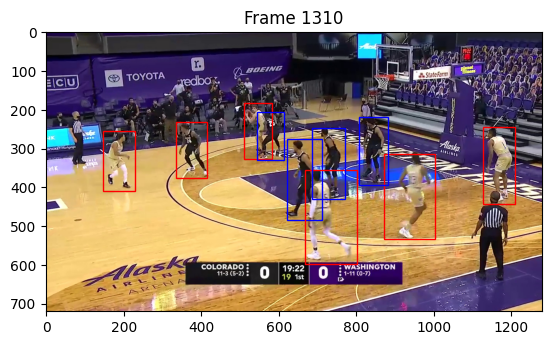

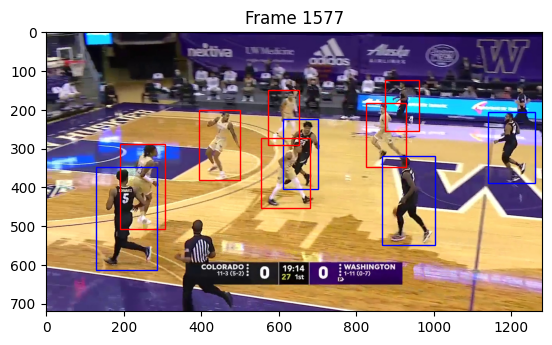

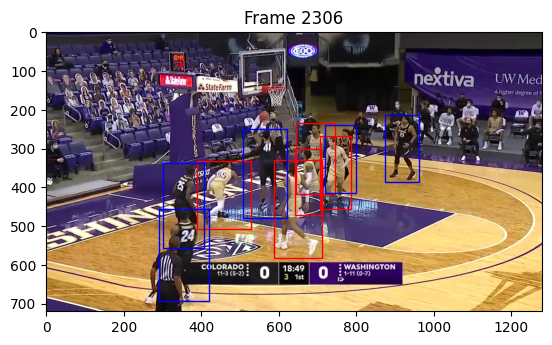

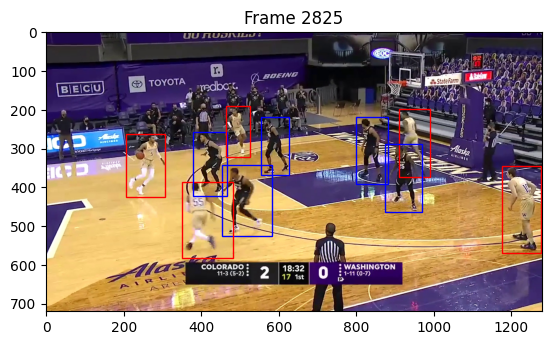

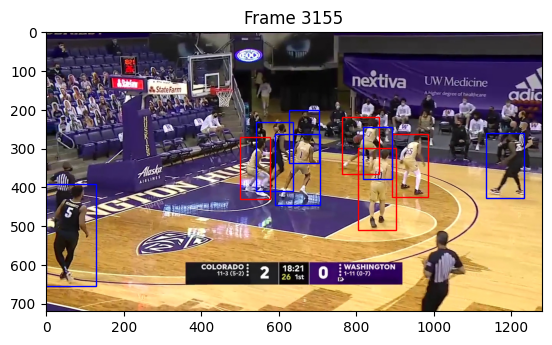

In [13]:
from itertools import islice

for frame_number, frame_data in dict(islice(bboxes_data.items(), 5)).items():
  frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
  if os.path.exists(frame_path):
    frame_img = Image.open(frame_path)
    plt.imshow(frame_img)
    plt.title(f"Frame {frame_number}")
    # <!-- Отображаем bounding boxes -->
    for player_data in bboxes_data[frame_number].values():
        box = player_data['box']
        team_id = player_data['team']

        x, y, w, h = box
        img_width, img_height = frame_img.size
        x_min = int(x * img_width)
        y_min = int(y * img_height)
        x_max = int((x + w) * img_width)
        y_max = int((y + h) * img_height)

        rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, edgecolor='r' if team_id == 0 else 'b', facecolor='none')
        plt.gca().add_patch(rect)

  plt.show()

# Классификация игроков на основе среднего цвета в пространстве RGB

## Подход K-Means

In [14]:
# Пример обработки всех кадров
all_features = []
all_true_labels = []  # Список для хранения истинных меток
all_predicted_labels = []  # Список для хранения предсказанных меток

# Функция для классификации игроков в пределах одного кадра
def classify_players_in_frame(features):
    # Используем K-Means для разделения игроков на 2 группы по цвету
    kmeans = KMeans(n_clusters=2, random_state=42)

    # Извлекаем признаки (средние значения RGB)
    rgb_values = [f['mean'] for f in features]

    # Обучаем K-Means на текущем кадре
    kmeans.fit(rgb_values)

    # Присваиваем каждому игроку метку кластера
    labels = kmeans.labels_

    # Обновляем команды на основе кластеризации
    for i, feature in enumerate(features):
        feature['predicted_team'] = labels[i]


# Обработка всех кадров
for frame_number, frame_data in bboxes_data.items():
    frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
    frame_img = Image.open(frame_path)
    frame_features, frame_labels = extract_features_for_frame(frame_number, frame_data, frame_img)

    # Классифицируем игроков внутри текущего кадра
    classify_players_in_frame(frame_features)

    # Собираем предсказанные метки и истинные метки
    predicted_labels = [f['predicted_team'] for f in frame_features]
    true_labels = frame_labels  # истинные метки

    all_features.extend(frame_features)
    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [15]:
if len(all_true_labels) == 0 or len(all_predicted_labels) == 0:
    print("No labels to calculate accuracy.")
else:
    overall_accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    print(f"Overall accuracy: {overall_accuracy}")

Overall accuracy: 0.529


## Подход с обучением K-Nearest Neighbors, RandomForest, GaussianNB

In [16]:
# Выбор модели классификатора
knn_model = KNeighborsClassifier(n_neighbors=3)
rf_model = RandomForestClassifier(n_estimators=100)
nb_model = GaussianNB()
knn_accuracy_scores = []
forest_accuracy_scores = []
gaussian_nb_accuracy_scores = []

# Перебираем все кадры
for frame_number, frame_data in bboxes_data.items():
    # Загружаем изображение кадра
    frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
    frame_img = Image.open(frame_path)

    # Извлекаем признаки и метки
    features, labels = extract_features_labels_for_frame(frame_number, frame_data, frame_img)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Обучаем модели на текущем кадре и предсказываем
    knn_model.fit(X_train, y_train)
    rf_model.fit(X_train, y_train)
    nb_model.fit(X_train, y_train)

    # Прогнозы для текущего кадра (можно использовать для оценки качества)
    knn_predictions = knn_model.predict(X_test)
    rf_predictions = rf_model.predict(X_test)
    nb_predictions = nb_model.predict(X_test)

    knn_accuracy = accuracy_score(y_test, knn_predictions)
    knn_accuracy_scores.append(knn_accuracy)

    rf_accuracy = accuracy_score(y_test, rf_predictions)
    forest_accuracy_scores.append(rf_accuracy)

    gaussian_nb_accuracy = accuracy_score(y_test, nb_predictions)
    gaussian_nb_accuracy_scores.append(gaussian_nb_accuracy)

print(f'KNN: {knn_accuracy_scores}')
print(f'RandomForest: {forest_accuracy_scores}')
print(f'Gaussian: {gaussian_nb_accuracy_scores}')

KNN: [0.6666666666666666, 0.0, 1.0, 1.0, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 1.0, 0.6666666666666666, 0.0, 0.6666666666666666, 0.0, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.0, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.3333333333333333, 0.3333333333333333, 1.0, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 1.0, 1.0, 0.6666666666666666, 0.0, 1.0, 0.6666666666666666, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.0, 0.3333333333333333, 0.3333333333333333, 0.6666666666666666, 0.6666666666666666,

# Классификация игроков на основе среднего цвета в пространстве HSV

## Подход K-Means

In [17]:
# Пример обработки всех кадров
all_features = []
all_true_labels = []  # Список для хранения истинных меток
all_predicted_labels = []  # Список для хранения предсказанных меток

# Функция для классификации игроков в пределах одного кадра
def classify_players_in_frame(features):
    # Используем K-Means для разделения игроков на 2 группы по цвету
    kmeans = KMeans(n_clusters=2, random_state=42)

    # Извлекаем признаки (средние значения RGB)
    rgb_values = [f['mean'] for f in features]

    # Обучаем K-Means на текущем кадре
    kmeans.fit(rgb_values)

    # Присваиваем каждому игроку метку кластера
    labels = kmeans.labels_

    # Обновляем команды на основе кластеризации
    for i, feature in enumerate(features):
        feature['predicted_team'] = labels[i]


# Обработка всех кадров
for frame_number, frame_data in bboxes_data.items():
    frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
    frame_img = Image.open(frame_path)
    frame_features, frame_labels = extract_features_for_frame(frame_number, frame_data, frame_img, format='hsv')

    # Классифицируем игроков внутри текущего кадра
    classify_players_in_frame(frame_features)

    # Собираем предсказанные метки и истинные метки
    predicted_labels = [f['predicted_team'] for f in frame_features]
    true_labels = frame_labels  # истинные метки

    all_features.extend(frame_features)
    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [18]:
if len(all_true_labels) == 0 or len(all_predicted_labels) == 0:
    print("No labels to calculate accuracy.")
else:
    overall_accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    print(f"Overall accuracy: {overall_accuracy}")

Overall accuracy: 0.512


## Подход с обучением K-Nearest Neighbors, RandomForest, GaussianNB

In [19]:
# Выбор модели классификатора
knn_model = KNeighborsClassifier(n_neighbors=3)
rf_model = RandomForestClassifier(n_estimators=100)
nb_model = GaussianNB()

all_knn_predictions = []
all_rf_predictions = []
all_nb_predictions = []
all_labels = []

# Перебираем все кадры
for frame_number, frame_data in bboxes_data.items():
    # Загружаем изображение кадра
    frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
    frame_img = Image.open(frame_path)

    # Извлекаем признаки и метки
    features, labels = extract_features_labels_for_frame(frame_number, frame_data, frame_img, 'hsv')
    # X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Обучаем модели на текущем кадре и предсказываем
    knn_model.fit(features, labels)
    rf_model.fit(features, labels)
    nb_model.fit(features, labels)

    # Прогнозы для текущего кадра (можно использовать для оценки качества)
    knn_predictions = knn_model.predict(features)
    rf_predictions = rf_model.predict(features)
    nb_predictions = nb_model.predict(features)

    # Накапливаем предсказания и метки
    all_knn_predictions.extend(knn_predictions)
    all_rf_predictions.extend(rf_predictions)
    all_nb_predictions.extend(nb_predictions)
    all_labels.extend(labels)

# Рассчитываем итоговую точность
knn_final_accuracy = accuracy_score(all_labels, all_knn_predictions)
rf_final_accuracy = accuracy_score(all_labels, all_rf_predictions)
nb_final_accuracy = accuracy_score(all_labels, all_nb_predictions)

# Выводим итоговую точность
print(f"Final KNN accuracy: {knn_final_accuracy}")
print(f"Final Random Forest accuracy: {rf_final_accuracy}")
print(f"Final Naive Bayes accuracy: {nb_final_accuracy}")

Final KNN accuracy: 0.778
Final Random Forest accuracy: 1.0
Final Naive Bayes accuracy: 0.795


# Классификация игроков на основе гистограммы в пространстве RGB

## Подход K-Means

In [20]:
# Пример обработки всех кадров
all_features = []
all_true_labels = []  # Список для хранения истинных меток
all_predicted_labels = []  # Список для хранения предсказанных меток

# Функция для классификации игроков в пределах одного кадра
def classify_players_in_frame(features):
    # Используем K-Means для разделения игроков на 2 группы по цвету
    kmeans = KMeans(n_clusters=2, random_state=42)

    # Извлекаем признаки (средние значения RGB)
    rgb_values = [f['hist'] for f in features]

    # Обучаем K-Means на текущем кадре
    kmeans.fit(rgb_values)

    # Присваиваем каждому игроку метку кластера
    labels = kmeans.labels_

    # Обновляем команды на основе кластеризации
    for i, feature in enumerate(features):
        feature['predicted_team'] = labels[i]


# Обработка всех кадров
for frame_number, frame_data in bboxes_data.items():
    frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
    frame_img = Image.open(frame_path)
    frame_features, frame_labels = extract_histogram_features_for_frame(frame_number, frame_data, frame_img)

    # Классифицируем игроков внутри текущего кадра
    classify_players_in_frame(frame_features)

    # Собираем предсказанные метки и истинные метки
    predicted_labels = [f['predicted_team'] for f in frame_features]
    true_labels = frame_labels  # истинные метки

    all_features.extend(frame_features)
    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [21]:
if len(all_true_labels) == 0 or len(all_predicted_labels) == 0:
    print("No labels to calculate accuracy.")
else:
    overall_accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    print(f"Overall accuracy: {overall_accuracy}")

Overall accuracy: 0.518


## Подход с обучением K-Nearest Neighbors, RandomForest, GaussianNB

In [22]:
# Выбор модели классификатора
knn_model = KNeighborsClassifier(n_neighbors=3)
rf_model = RandomForestClassifier(n_estimators=100)
nb_model = GaussianNB()

all_knn_predictions = []
all_rf_predictions = []
all_nb_predictions = []
all_labels = []

# Перебираем все кадры
for frame_number, frame_data in bboxes_data.items():
    # Загружаем изображение кадра
    frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
    frame_img = Image.open(frame_path)

    # Извлекаем признаки и метки
    features, labels = extract_histogram_features_labels_for_frame(frame_number, frame_data, frame_img)

    # Обучаем модели на текущем кадре и предсказываем
    knn_model.fit(features, labels)
    rf_model.fit(features, labels)
    nb_model.fit(features, labels)

    # Прогнозы для текущего кадра (можно использовать для оценки качества)
    knn_predictions = knn_model.predict(features)
    rf_predictions = rf_model.predict(features)
    nb_predictions = nb_model.predict(features)

    # Накапливаем предсказания и метки
    all_knn_predictions.extend(knn_predictions)
    all_rf_predictions.extend(rf_predictions)
    all_nb_predictions.extend(nb_predictions)
    all_labels.extend(labels)

# Рассчитываем итоговую точность
knn_final_accuracy = accuracy_score(all_labels, all_knn_predictions)
rf_final_accuracy = accuracy_score(all_labels, all_rf_predictions)
nb_final_accuracy = accuracy_score(all_labels, all_nb_predictions)

# Выводим итоговую точность
print(f"Final KNN accuracy: {knn_final_accuracy}")
print(f"Final Random Forest accuracy: {rf_final_accuracy}")
print(f"Final Naive Bayes accuracy: {nb_final_accuracy}")

Final KNN accuracy: 0.799
Final Random Forest accuracy: 1.0
Final Naive Bayes accuracy: 0.961


# Классификация игроков на основе гистограммы в пространстве HSV

## Подход K-Means

In [23]:
# Пример обработки всех кадров
all_features = []
all_true_labels = []  # Список для хранения истинных меток
all_predicted_labels = []  # Список для хранения предсказанных меток

# Функция для классификации игроков в пределах одного кадра
def classify_players_in_frame(features):
    # Используем K-Means для разделения игроков на 2 группы по цвету
    kmeans = KMeans(n_clusters=2, random_state=42)

    # Извлекаем признаки (средние значения RGB)
    rgb_values = [f['hist'] for f in features]

    # Обучаем K-Means на текущем кадре
    kmeans.fit(rgb_values)

    # Присваиваем каждому игроку метку кластера
    labels = kmeans.labels_

    # Обновляем команды на основе кластеризации
    for i, feature in enumerate(features):
        feature['predicted_team'] = labels[i]


# Обработка всех кадров
for frame_number, frame_data in bboxes_data.items():
    frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
    frame_img = Image.open(frame_path)
    frame_features, frame_labels = extract_histogram_features_for_frame(frame_number, frame_data, frame_img, format='hsv')

    # Классифицируем игроков внутри текущего кадра
    classify_players_in_frame(frame_features)

    # Собираем предсказанные метки и истинные метки
    predicted_labels = [f['predicted_team'] for f in frame_features]
    true_labels = frame_labels  # истинные метки

    all_features.extend(frame_features)
    all_true_labels.extend(true_labels)
    all_predicted_labels.extend(predicted_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` ex

In [24]:
if len(all_true_labels) == 0 or len(all_predicted_labels) == 0:
    print("No labels to calculate accuracy.")
else:
    overall_accuracy = accuracy_score(all_true_labels, all_predicted_labels)
    print(f"Overall accuracy: {overall_accuracy}")

Overall accuracy: 0.491


## Подход с обучением K-Nearest Neighbors, RandomForest, GaussianNB

In [25]:
# Выбор модели классификатора
knn_model = KNeighborsClassifier(n_neighbors=3)
rf_model = RandomForestClassifier(n_estimators=100)
nb_model = GaussianNB()

all_knn_predictions = []
all_rf_predictions = []
all_nb_predictions = []
all_labels = []

# Перебираем все кадры
for frame_number, frame_data in bboxes_data.items():
    # Загружаем изображение кадра
    frame_path = os.path.join(frames_dir, f"{frame_number}.jpeg")
    frame_img = Image.open(frame_path)

    # Извлекаем признаки и метки
    features, labels = extract_histogram_features_labels_for_frame(frame_number, frame_data, frame_img, 'hsv')
    # X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

    # Обучаем модели на текущем кадре и предсказываем
    knn_model.fit(features, labels)
    rf_model.fit(features, labels)
    nb_model.fit(features, labels)

    # Прогнозы для текущего кадра (можно использовать для оценки качества)
    knn_predictions = knn_model.predict(features)
    rf_predictions = rf_model.predict(features)
    nb_predictions = nb_model.predict(features)

    # Накапливаем предсказания и метки
    all_knn_predictions.extend(knn_predictions)
    all_rf_predictions.extend(rf_predictions)
    all_nb_predictions.extend(nb_predictions)
    all_labels.extend(labels)

# Рассчитываем итоговую точность
knn_final_accuracy = accuracy_score(all_labels, all_knn_predictions)
rf_final_accuracy = accuracy_score(all_labels, all_rf_predictions)
nb_final_accuracy = accuracy_score(all_labels, all_nb_predictions)

# Выводим итоговую точность
print(f"Final KNN accuracy: {knn_final_accuracy}")
print(f"Final Random Forest accuracy: {rf_final_accuracy}")
print(f"Final Naive Bayes accuracy: {nb_final_accuracy}")

Final KNN accuracy: 0.762
Final Random Forest accuracy: 1.0
Final Naive Bayes accuracy: 0.968
